In [1]:
import pandas as pd #data manipulation
from tqdm.auto import tqdm #progress bar
from rdkit import Chem #Chemistry
from rdkit.Chem import rdMolDescriptors #molecular descriptors
import numpy as np #matrix algebra
from lightgbm import LGBMRegressor, plot_importance #LightGBM models
from sklearn.model_selection import train_test_split #ML training
from sklearn.metrics import r2_score, mean_squared_error #ML stats
import seaborn as sns #Plotting
from yellowbrick.regressor import prediction_error, ResidualsPlot
from tdc.single_pred import ADME

In [2]:
sns.set_context('talk')

In [3]:
tqdm.pandas()

In [4]:
data = ADME(name = 'Solubility_AqSolDB')
sol_df = data.get_data()
sol_df.columns = ["Name","SMILES","LogS"]
sol_df

Found local copy...
Loading...
Done!


,Name,SMILES,LogS
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065
...,...,...,...
9977,tetracaine,CCCCNc1ccc(C(=O)OCCN(C)C)cc1,-3.010000
9978,tetracycline,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,-2.930000
9979,thymol,Cc1ccc(C(C)C)c(O)c1,-2.190000
9980,verapamil,COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C...,-3.980000


Set up property calculations

In [5]:
property_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
property_getter = rdMolDescriptors.Properties(property_names)

In [6]:
property_names

['exactmw',
 'amw',
 'lipinskiHBA',
 'lipinskiHBD',
 'NumRotatableBonds',
 'NumHBD',
 'NumHBA',
 'NumHeavyAtoms',
 'NumAtoms',
 'NumHeteroatoms',
 'NumAmideBonds',
 'FractionCSP3',
 'NumRings',
 'NumAromaticRings',
 'NumAliphaticRings',
 'NumSaturatedRings',
 'NumHeterocycles',
 'NumAromaticHeterocycles',
 'NumSaturatedHeterocycles',
 'NumAliphaticHeterocycles',
 'NumSpiroAtoms',
 'NumBridgeheadAtoms',
 'NumAtomStereoCenters',
 'NumUnspecifiedAtomStereoCenters',
 'labuteASA',
 'tpsa',
 'CrippenClogP',
 'CrippenMR',
 'chi0v',
 'chi1v',
 'chi2v',
 'chi3v',
 'chi4v',
 'chi0n',
 'chi1n',
 'chi2n',
 'chi3n',
 'chi4n',
 'hallKierAlpha',
 'kappa1',
 'kappa2',
 'kappa3',
 'Phi']

Define a function to calculate properties from SMILES

In [7]:
def smi2props(smi):
    mol = Chem.MolFromSmiles(smi)
    props = None
    if mol:
        Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1X0]"))
        props = np.array(property_getter.ComputeProperties(mol))
    return props

In [8]:
sol_df['props'] = sol_df.SMILES.progress_apply(smi2props)

  0%|          | 0/9982 [00:00<?, ?it/s]

[12:19:09] WARNING: not removing hydrogen atom without neighbors
[12:19:10] WARNING: not removing hydrogen atom without neighbors
[12:19:10] WARNING: not removing hydrogen atom without neighbors
[12:19:12] WARNING: not removing hydrogen atom without neighbors
[12:19:13] WARNING: not removing hydrogen atom without neighbors
[12:19:14] WARNING: not removing hydrogen atom without neighbors
[12:19:15] WARNING: not removing hydrogen atom without neighbors
[12:19:16] WARNING: not removing hydrogen atom without neighbors
[12:19:16] WARNING: not removing hydrogen atom without neighbors
[12:19:17] WARNING: not removing hydrogen atom without neighbors
[12:19:17] WARNING: not removing hydrogen atom without neighbors
[12:19:18] WARNING: not removing hydrogen atom without neighbors
[12:19:25] WARNING: not removing hydrogen atom without neighbors
[12:19:25] WARNING: not removing hydrogen atom without neighbors
[12:19:25] WARNING: not removing hydrogen atom without neighbors
[12:19:25] WARNING: not r

In [9]:
sol_df[property_names] = sol_df['props'].to_list()

In [10]:
sol_df.head()

,Name,SMILES,LogS,props,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,...,chi0n,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127,"[391.28136257200003, 392.50999999999993, 1.0, ...",391.281363,392.510,1.0,0.0,17.0,0.0,...,16.845993,10.364975,4.682488,4.682488,3.134242,0.440000,25.677560,18.774017,24.808021,20.959606
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767,"[169.052763844, 169.18299999999996, 2.0, 1.0, ...",169.052764,169.183,2.0,1.0,0.0,1.0,...,6.872350,4.192158,2.397526,2.397526,1.824022,-1.830000,6.660756,2.102073,0.745786,1.077031
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078,"[140.00289246, 140.569, 1.0, 0.0, 1.0, 0.0, 1....",140.002892,140.569,1.0,0.0,1.0,0.0,...,4.672964,2.534727,1.006088,1.006088,0.541348,-0.820000,6.302249,2.646097,1.541347,1.852930
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409,"[754.227281264, 756.2260000000001, 6.0, 2.0, 1...",754.227281,756.226,6.0,2.0,10.0,2.0,...,30.400335,17.334648,9.894590,9.894590,6.542454,-5.516623,40.256883,18.303167,9.483471,13.902423
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065,"[422.22055743999994, 422.52500000000026, 6.0, ...",422.220557,422.525,6.0,0.0,12.0,0.0,...,17.819585,11.425462,6.316788,6.316788,4.132685,-2.120000,19.556716,8.431191,5.573965,5.318916


In [11]:
train, test = train_test_split(sol_df)

In [12]:
train_X = train[property_names]
train_y = train.LogS
test_X = test[property_names]
test_y = test.LogS

In [13]:
lgbm = LGBMRegressor()

In [14]:
lgbm.fit(train_X, train_y)

LGBMRegressor()

In [15]:
lgbm.score(train_X, train_y)

0.8837279111605033

In [16]:
pred = lgbm.predict(test_X)

[Text(0, 0.5, 'Predicted LogS')]

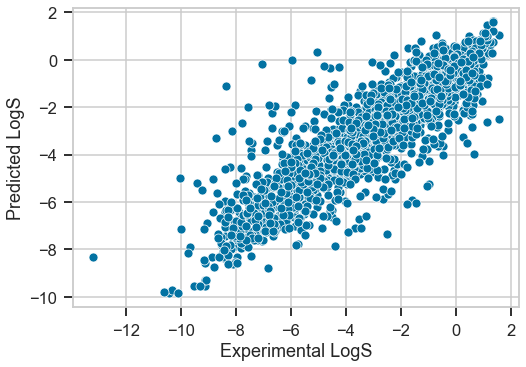

In [17]:
ax = sns.scatterplot(x=test_y,y=pred)
ax.set(xlabel="Experimental LogS")
ax.set(ylabel="Predicted LogS")

[Text(0, 0.5, 'Predicted LogS')]

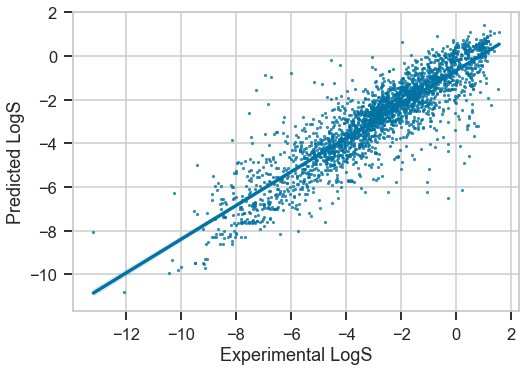

In [21]:
ax = sns.regplot(x=test_y,y=pred,scatter_kws={'s':10})
ax.set(xlabel="Experimental LogS")
ax.set(ylabel="Predicted LogS")

In [22]:
r2_score(test_y,pred)

0.7862049799657214

In [23]:
mean_squared_error(test_y,pred,squared=False)

1.0935299673024454

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

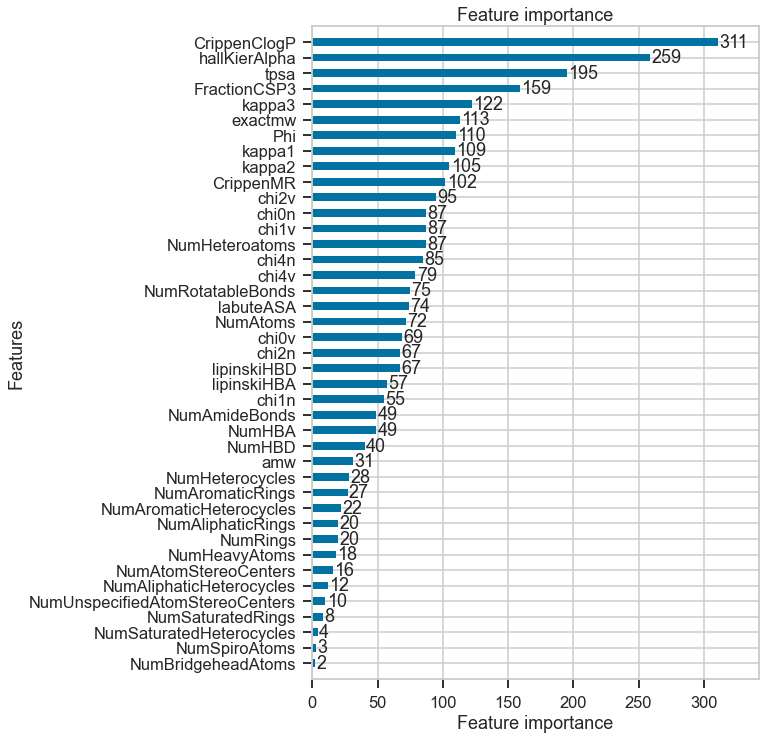

In [24]:
plot_importance(lgbm,figsize=(8,12),height=0.5)

In [25]:
lgbm = LGBMRegressor()
train, test = train_test_split(sol_df)
train_X = train[property_names]
train_y = train.LogS
test_X = test[property_names]
test_y = test.LogS

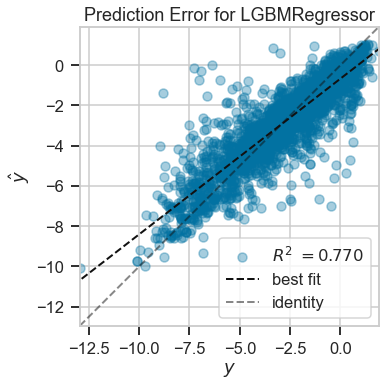

In [26]:
visualizer = prediction_error(lgbm, train_X, train_y, test_X, test_y,alpha=0.35)

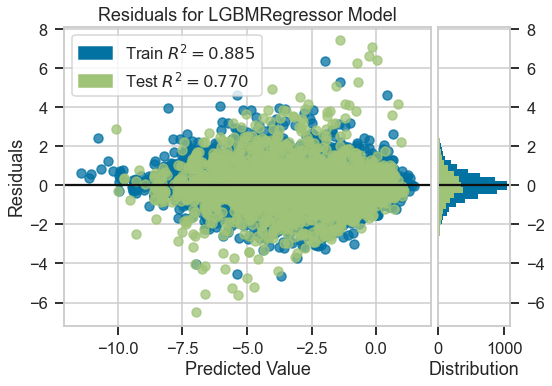

In [27]:
visualizer = ResidualsPlot(lgbm)
visualizer.fit(train_X, train_y)
visualizer.score(test_X, test_y)
visualizer.show();

Run 10 cycles of cross validation on a model

In [28]:
r2_list = []
for i in tqdm(range(0,10)):
    # setup training and test sets
    train, test = train_test_split(sol_df)
    train_X = train[property_names]
    train_y = train.LogS
    test_X = test[property_names]
    test_y = test.LogS
    # create the regressor
    lgbm = LGBMRegressor()
    # train the model
    lgbm.fit(train_X,train_y)
    pred = lgbm.predict(test_X)
    r2 = r2_score(test_y,pred)
    print(r2)
    r2_list.append(r2)

  0%|          | 0/10 [00:00<?, ?it/s]

0.8040225569040962
0.7757544032561811
0.7749178255635049
0.7811320372078412
0.7893891120069332
0.7702716665348874
0.778893673655489
0.7962931902603823
0.7778489006882613
0.7786295522689625


[Text(0.5, 0, 'R$^2$')]

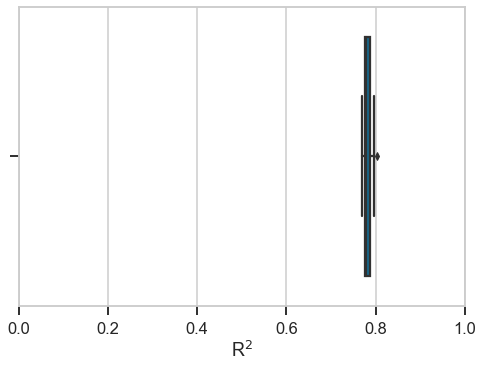

In [29]:
ax = sns.boxplot(x=r2_list)
ax.set(xlim=(0,1))
ax.set(xlabel="R$^2$")

### Conclusion:

We have built LGBM regressor model with ~88% accuracy. 

'CrippenClogp' is top feature in deciding the compound solubility. 